### Titanic: Machine Learning from Disaster
Nada mais justo do que realizar o "Hello World" do machine learning.

In [65]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, cross_validate
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
warnings.filterwarnings('ignore')
%matplotlib inline

Importando os dados

In [66]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

print(f'Treino: {df_train.shape}')
print(f'Teste: {df_test.shape}')

Treino: (891, 12)
Teste: (418, 11)


#### Data Cleaning

In [67]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [68]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


**Missing Values**

In [69]:
print('Train Dataframe \n')
print(df_train.isnull().sum())
print('\nTest Dataframe \n' )
print(df_test.isnull().sum())

Train Dataframe 

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Test Dataframe 

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


Quatro features apresentam valores nulos: Age, Cabin, Embarked e Fare. Existem diversas abordagens para tratar esses dados, porém, a abordagem adotada será:
- Preencher os valores nulos de Age pela média de idade de acordo com o PClass do passageiro
- Tentar extrair informações de Cabin (situação crítica), em caso de falha iremos abandonar essa feature.
- Preencher Embarked com o valor mais frequente.
- Preencher Fare com o valor mais frequente.

In [70]:
#Input age
def age_input(x, df):
    age_map = df.groupby('Pclass').mean()['Age']
    
    if x['Pclass'] == 1:
        return np.round(age_map[1])
    elif x['Pclass'] == 2:
        return np.round(age_map[2])
    else:
        return np.round(age_map[3])
    
#Aplicando a função em Age
#Salvando a distribuição atual de idade
old_train_age = df_train.Age
old_test_age = df_test.Age

#Aplicando
df_train.loc[df_train.Age.isnull(), 'Age'] = df_train.loc[df_train.Age.isnull()].apply(lambda x: age_input(x, df_train), axis = 1)
df_test.loc[df_test.Age.isnull(), 'Age'] = df_test.loc[df_test.Age.isnull()].apply(lambda x: age_input(x, df_test), axis = 1)

#Conferindo resultado

print('Train Dataframe \n')
print(df_train.isnull().sum())
print('\nTest Dataframe \n' )
print(df_test.isnull().sum())

Train Dataframe 

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Test Dataframe 

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [71]:
df_train.shape

(891, 12)

Antes de continuar com a limpeza de valores nulos, vamos avaliar o impacto das mudanças que realizamos em idade.

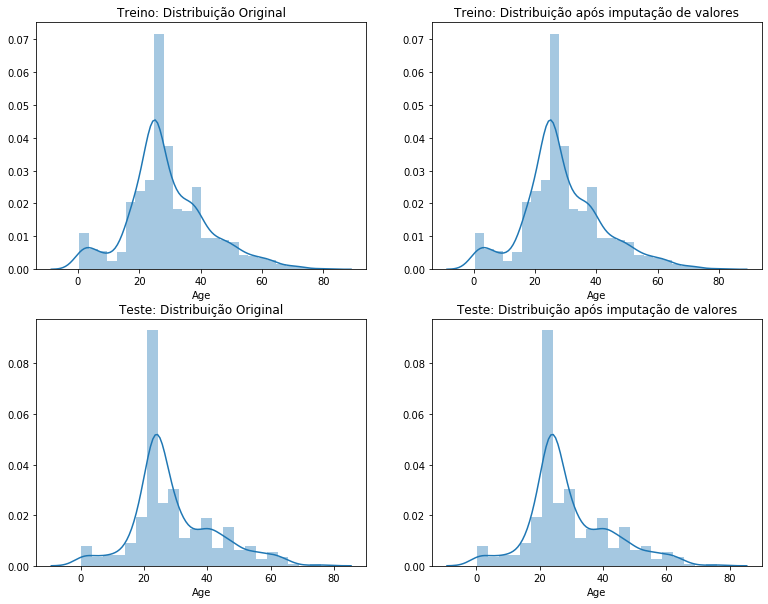

In [72]:
fig, ax = plt.subplots(2,2,figsize=(13,10))
sns.distplot(old_train_age,ax = ax[0,0])
sns.distplot(df_train.Age, ax = ax[0,1])
ax[0,0].set_title('Treino: Distribuição Original')
ax[0,1].set_title('Treino: Distribuição após imputação de valores')
sns.distplot(old_test_age,ax = ax[1,0])
sns.distplot(df_test.Age, ax = ax[1,1])
ax[1,0].set_title('Teste: Distribuição Original')
ax[1,1].set_title('Teste: Distribuição após imputação de valores')
plt.show()

##### Cabin
Cabin é a variável com maior número de valores faltantes, porém, vamos tentar realizar alguns procedimentos para tentar "salvar" essa feature. A abordagem utilizada será a de que pessoas da mesma família habitam a mesma cabine.

In [73]:
#Criando feature de sobrenomes
def create_surname(df):
    df['Surname'] = df.Name.apply(lambda x: re.search('\w+', x)[0])
    return df

#Agora, podemos extrair informações a respeito de Cabines e Sobrenomes
surname_data = create_surname(df_train.loc[df_train.Cabin.notnull(),:])[['Cabin', 'Surname']]
surname_data.head()

,Cabin,Surname
1,C85,Cumings
3,C123,Futrelle
6,E46,McCarthy
10,G6,Sandstrom
11,C103,Bonnell


In [74]:
#Vamos remover as cabines duplicadas.
print(f'Original: {surname_data.shape}')
surname_data.drop_duplicates(subset = 'Surname',inplace=True)
print(f'Após drop de duplicatas: {surname_data.shape}')

Original: (204, 2)
Após drop de duplicatas: (157, 2)


In [75]:
#Fazendo join em nosso dataframe original
#Criando surnames
df_train = create_surname(df_train)
#Dropando Cabin atual
df_train.drop('Cabin', axis = 1, inplace = True)
#Realizando join
df_train = df_train.merge(surname_data, on = 'Surname', how = 'left')

#Extraindo a classe da cabine
df_train.loc[df_train.Cabin.notnull(), 'Cabin'] = df_train.loc[df_train.Cabin.notnull(), 'Cabin'].apply(lambda x: x[0])
#Conferindo o resultado
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         2
Surname          0
Cabin          660
dtype: int64

Infelizmente a abordagem não surtiu grandes resultados. Para manter Cabin em nossa modelagem, iremos atribuir "Z" para as cabines nulas.

In [76]:
df_train['Cabin'] = df_train.Cabin.fillna('Z')
df_train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       2
Surname        0
Cabin          0
dtype: int64

In [77]:
#Aplicando todos os procedimentos anteriores para os dados de teste.

surname_data = create_surname(df_test.loc[df_test.Cabin.notnull(),:])[['Cabin', 'Surname']]
surname_data.drop_duplicates(subset = 'Surname', inplace=True)
#Criando surnames
df_test = create_surname(df_test)
#Dropando Cabin atual
df_test.drop('Cabin', axis = 1, inplace = True)
#Realizando join
df_test = df_test.merge(surname_data, on = 'Surname', how = 'left')
df_test.loc[df_test.Cabin.notnull(), 'Cabin'] = df_test.loc[df_test.Cabin.notnull(), 'Cabin'].apply(lambda x: x[0])
df_test['Cabin'] = df_test.Cabin.fillna('Z')
#Conferindo o resultado
df_test.isnull().sum()


PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           1
Embarked       0
Surname        0
Cabin          0
dtype: int64

##### Flare and Embarked
Treino possui 2 registros faltantes em Embarked, Teste possui 1 registro faltante em Fare

In [78]:
#Embarked
#Valor mais frequente
#df_train.groupby('Embarked').count()
#S é a classe predominante.
df_train['Embarked'] = df_train.Embarked.fillna('S')

#Fare
df_test['Fare'] = df_test.Fare.fillna(df_test.Fare.mean())

#Visualizando
print('Train Dataframe \n')
print(df_train.isnull().sum())
print('\nTest Dataframe \n' )
print(df_test.isnull().sum())


Train Dataframe 

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Surname        0
Cabin          0
dtype: int64

Test Dataframe 

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Surname        0
Cabin          0
dtype: int64


### EDA
Todo mundo gosta de gráficos, vamos começar analisando os sobreviventes.

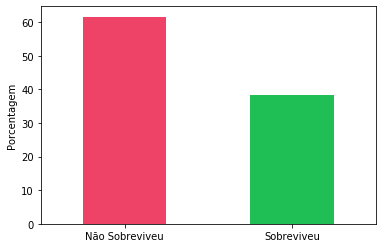

In [79]:
#Survival rate
#Structure
fig, ax = plt.subplots()
survival_rate = np.round((df_train.groupby('Survived').count()['Pclass'] / len(df_train)) * 100, 1)
survival_rate.plot(kind='bar', color = ['#EE4266', '#20BF55'])
#Labels
ax.set_xticklabels(['Não Sobreviveu', 'Sobreviveu'], rotation = 0, fontsize = 10)
ax.set_ylabel('Porcentagem')
ax.set_xlabel('')
plt.show()

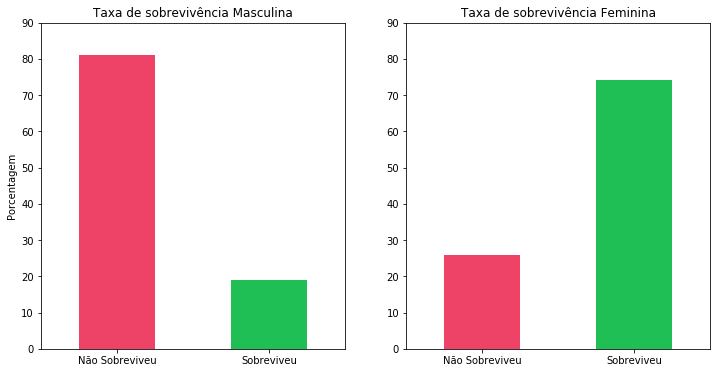

In [80]:
#Survival Rate por Sexo
fig, ax = plt.subplots(1,2,figsize=(12,6))
#Data
s_h = np.round((df_train.loc[df_train.Sex == 'male'].groupby('Survived').count()['Pclass'] / len(df_train.loc[df_train.Sex == 'male'])) * 100, 1)
s_m = np.round((df_train.loc[df_train.Sex == 'female'].groupby('Survived').count()['Pclass'] / len(df_train.loc[df_train.Sex == 'female'])) * 100, 1)

#Plots
s_h.plot(kind='bar', color = ['#EE4266', '#20BF55'], ax = ax[0])
s_m.plot(kind='bar', color = ['#EE4266', '#20BF55'], ax = ax[1])

#Labels
ax[0].set_xticklabels(['Não Sobreviveu', 'Sobreviveu'], rotation = 0, fontsize = 10)
ax[0].set_ylabel('Porcentagem')
ax[0].set_xlabel('')
ax[0].set_title('Taxa de sobrevivência Masculina')
ax[0].set_ylim([0,90])

ax[1].set_xticklabels(['Não Sobreviveu', 'Sobreviveu'], rotation = 0, fontsize = 10)
ax[1].set_xlabel('')
ax[1].set_title('Taxa de sobrevivência Feminina')
ax[1].set_ylim([0,90])

plt.show()

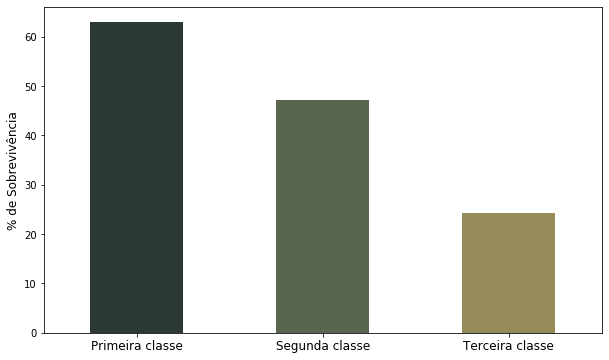

In [81]:
#% de Sobreviventes por PClass
#Data
s_pclass = (df_train.groupby('Pclass').apply(lambda x: x.loc[x.Survived == 1].count()['Cabin'] / len(x))) * 100

#Plot
fig, ax = plt.subplots(figsize=(10,6))
s_pclass.plot(kind='bar', color = ['#2C3833', '#59654E', '#968C59'], ax = ax)
ax.set_xticklabels(['Primeira classe', 'Segunda classe', 'Terceira classe'], rotation = 0, fontsize = 12)
ax.set_xlabel('')
ax.set_ylabel('% de Sobrevivência', fontsize = 12)
plt.show()

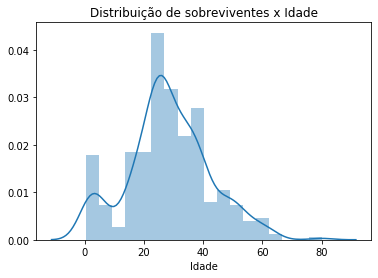

In [82]:
fig,ax = plt.subplots()
sns.distplot(df_train.loc[df_train.Survived == 1, 'Age'])
ax.set_title('Distribuição de sobreviventes x Idade')
ax.set_xlabel('Idade')
plt.show()

Os gráficos acima permitem concluir algumas coisas interessantes:
- Em termos gerais, apenas 40% dos tripulantes  a bordo do Titanic sobreviveram a tragédia.
- A taxa de sobrevivência das mulheres supera com folga a taxa de sobrevivência dos homens (O que faz sentido, visto que elas tinham prioridade no salvamento)
- A taxa de sobrevivência aumenta de acordo com a classe, sendo que a primeira classe é a unica classe que teve uma taxa de sobrevivência positiva (Cerca de 60% dos membros da primeira classe sobreviveram)
- Existe um pico de sobreviventes em faixas etárias menores (Bebês/crianças)

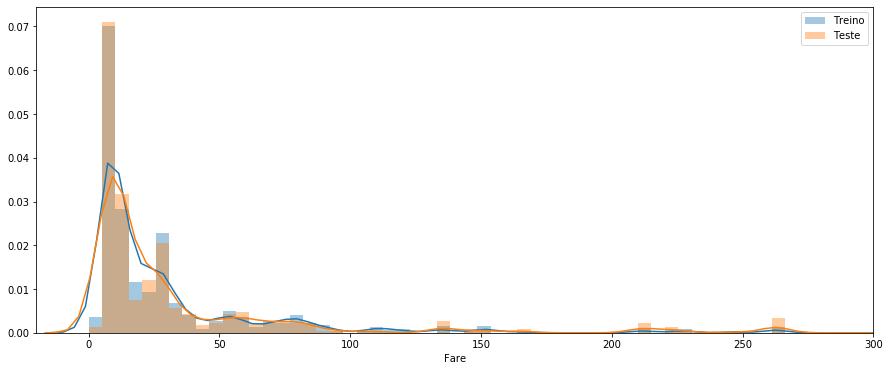

In [83]:
#Distribuição de fare
fig,ax = plt.subplots(figsize = (15,6))
sns.distplot(df_train.Fare, ax = ax, bins = 100)
sns.distplot(df_test.Fare, ax = ax, bins = 100)
ax.set_xlim((-20,300))
ax.legend(['Treino', 'Teste'])

Text(0.5, 1.0, 'Fare x Classe - Teste')

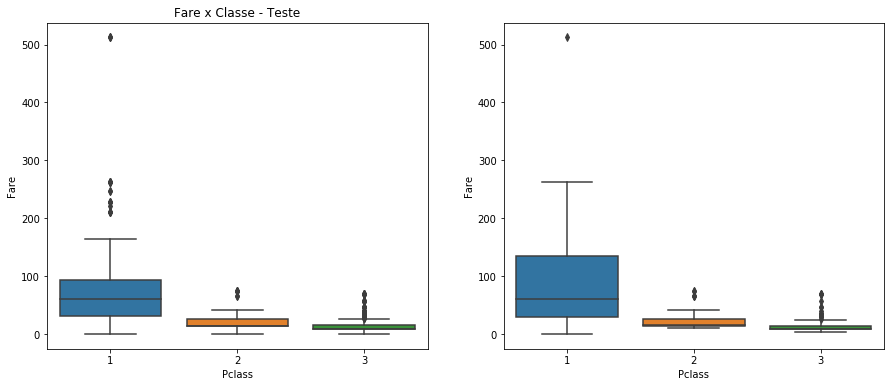

In [84]:
#Fare por PClass
fig,ax = plt.subplots(1,2,figsize=(15,6))
sns.boxplot(x = 'Pclass', y = 'Fare', data = df_train, ax = ax[0])
sns.boxplot(x = 'Pclass', y = 'Fare', data = df_test, ax = ax[1])
ax[0].set_title('Fare x Classe - Treino')
ax[0].set_title('Fare x Classe - Teste')


#### Feature Engineering

In [85]:
#dtypes
print(df_train.dtypes)
print('')
print(df_test.dtypes)

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Embarked        object
Surname         object
Cabin           object
dtype: object

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Embarked        object
Surname         object
Cabin           object
dtype: object


##### Criando Features
Iremos criar duas features:
- treat: Tratamento utilizado (Extraido do nome).
- is_alone: Indica se a pessoa estava sozinha no navio.

In [86]:
#Juntando dataframes
labels = df_train.Survived
df_train.drop('Survived', axis = 1, inplace = True)
df_train['Tipo'] = 'train'
df_test['Tipo'] = 'test'

#Verificando
print(df_train.shape[1] == df_test.shape[1])

#Realizando concat
df_full = pd.concat([df_train, df_test],axis = 0, sort = False)
print(df_full.shape)

True
(1309, 13)


In [87]:
#Criando variável - Treatment (Qual o tratamento utilizado)

def create_treatment(dataframes):
    for dataframe in dataframes:
        dataframe['treat'] = dataframe.Name.apply(lambda x: re.search('\w+\.', x)[0])

#Aplicando a função
create_treatment([df_full])

#Verificando o resultado
df_full.treat.unique()


array(['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Don.', 'Rev.', 'Dr.', 'Mme.',
       'Ms.', 'Major.', 'Lady.', 'Sir.', 'Mlle.', 'Col.', 'Capt.',
       'Countess.', 'Jonkheer.', 'Dona.'], dtype=object)

In [88]:
#Criando variável - is_alone (A pessoa estava sozinha?)

#Definindo funções
def is_alone(x):
    if (x['SibSp'] == 0) & (x['Parch'] == 0):
        return 1
    else:
        return 0

def create_alone(dataframes):
    for dataframe in dataframes:
        dataframe['is_alone'] = dataframe.apply(lambda x: is_alone(x), axis = 1)
        
#Aplicando a função
create_alone([df_full])

#Verificando o resultado
df_full.is_alone.unique()

array([0, 1], dtype=int64)

In [89]:
#Dummies
to_dummy = ['Sex', 'Embarked', 'Cabin', 'treat']

print(f'Shape original: {df_full.shape}')
#print(f'Shape teste original: {df_test.shape}')

df_full = pd.get_dummies(df_full, columns=to_dummy,drop_first = True)
#df_test = pd.get_dummies(df_test, columns=to_dummy, drop_first = True)

print(f'Shape após transformação: {df_full.shape}')
#print(f'Shape teste original: {df_test.shape}')


Shape original: (1309, 15)
Shape após transformação: (1309, 39)


In [90]:
df_full.head()

,PassengerId,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Surname,Tipo,...,treat_Major.,treat_Master.,treat_Miss.,treat_Mlle.,treat_Mme.,treat_Mr.,treat_Mrs.,treat_Ms.,treat_Rev.,treat_Sir.
0,1,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,Braund,train,...,0,0,0,0,0,1,0,0,0,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,Cumings,train,...,0,0,0,0,0,0,1,0,0,0
2,3,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,Heikkinen,train,...,0,0,1,0,0,0,0,0,0,0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,Futrelle,train,...,0,0,0,0,0,0,1,0,0,0
4,5,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,Allen,train,...,0,0,0,0,0,1,0,0,0,0


In [91]:
#Retornando com df_train e df_test
df_train = df_full.loc[df_full.Tipo == 'train',:].drop('Tipo',axis=1)
df_test = df_full.loc[df_full.Tipo == 'test',:].drop('Tipo',axis = 1)

#Verificando shapes
print(f'Treino: {df_train.shape}')
print(f'Teste: {df_test.shape}')

Treino: (891, 38)
Teste: (418, 38)


In [92]:
#Scaling de fare e age

scaler = StandardScaler()

def scaling(df):
    df['Fare'] = scaler.fit_transform(df[['Fare']])
    df['Age'] = scaler.fit_transform(df[['Age']])
    return df

#Aplicando
df_train = scaling(df_train)
df_test = scaling(df_test)

#Verificando
df_train.head()

,PassengerId,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Surname,is_alone,...,treat_Major.,treat_Master.,treat_Miss.,treat_Mlle.,treat_Mme.,treat_Mr.,treat_Mrs.,treat_Ms.,treat_Rev.,treat_Sir.
0,1,3,"Braund, Mr. Owen Harris",-0.550185,1,0,A/5 21171,-0.502445,Braund,0,...,0,0,0,0,0,1,0,0,0,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0.661499,1,0,PC 17599,0.786845,Cumings,0,...,0,0,0,0,0,0,1,0,0,0
2,3,3,"Heikkinen, Miss. Laina",-0.247264,0,0,STON/O2. 3101282,-0.488854,Heikkinen,1,...,0,0,1,0,0,0,0,0,0,0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0.434308,1,0,113803,0.420730,Futrelle,0,...,0,0,0,0,0,0,1,0,0,0
4,5,3,"Allen, Mr. William Henry",0.434308,0,0,373450,-0.486337,Allen,1,...,0,0,0,0,0,1,0,0,0,0


### Modelagem

#### Definindo as features

In [93]:
#X / Y
y = labels
x = df_train.drop(['PassengerId', 'Name', 'Ticket', 'Surname'], axis = 1)

#Para posterior previsão
df_test = df_test.drop(['PassengerId', 'Name', 'Ticket', 'Surname'], axis = 1)

#### Regressão Logística
Em um primeiro momento vamos utilizar regressão logística e avaliar os resultados.

In [94]:
splits = 10
folds = StratifiedKFold(n_splits= splits)
rl_model = LogisticRegression()
#rl_model.fit(x, y)

In [95]:
print(f'Score médio para {splits} splits: {cross_val_score(rl_model, x , y, cv=folds).mean()}')

Score médio para 10 splits: 0.8294722505958461


In [96]:
#Utilizando validação
x_train, x_test, y_train, y_test = train_test_split(x,y,stratify = y, train_size = 0.9)

#Fit
rl_model.fit(x_train, y_train)

#Predict
predictions = rl_model.predict(x_test)

#Classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86        55
           1       0.78      0.80      0.79        35

    accuracy                           0.83        90
   macro avg       0.82      0.83      0.83        90
weighted avg       0.83      0.83      0.83        90



É possível notar que nosso modelo não está performando muito bem nas previsões de pessoas que sobreviveram. Vamos tentar contornar isso.

In [97]:
#Usando pesos

weights = {1: 0.1, 0: 0.2}

rl_model = LogisticRegression(penalty='l1', class_weight=weights)
rl_model.fit(x_train, y_train)

#Predict
predictions = rl_model.predict(x_test)

#Classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.77      0.96      0.85        55
           1       0.90      0.54      0.68        35

    accuracy                           0.80        90
   macro avg       0.84      0.75      0.77        90
weighted avg       0.82      0.80      0.79        90



Embora a precision da classe "Sobreviveu" tenha aumentado, o recall caiu bastante. Vamos tentar aplicar uma regra "custom" para sobreviventes. Como observado na EDA, a taxa de sobrevivência para mulheres é de aproximadamente 75% enquanto a taxa de sobrevivência para homens é de apenas 20%, vamos então aplicar condições as probabilidades de sobrevivência baseando-se apenas no sexo do passageiro.

In [98]:
rl_model = LogisticRegression()
rl_model.fit(x_train, y_train)

#Condição customizada de sobrevivência
def condition(x, male_cond, female_cond):
    if x['Sex'] == 0:
        if x['Probability'] > female_cond:
            return 1
        else:
            return 0
    else:
        if x['Probability'] > male_cond:
            return 1
        else:
            return 0

#Função que aplica a condição
def custom_survive(test, male_cond, female_cond):
    prob_pred_1 = rl_model.predict_proba(test)[:,1]
    survived_df = pd.DataFrame({'Sex': test.Sex_male,
                               'Probability': prob_pred_1})
    
    survived_df['Survived'] = survived_df.apply(lambda x: condition(x, male_cond, female_cond), axis = 1)
    
    return survived_df

#Gerando dados
survived_info = custom_survive(x_test, 0.6, 0.4)

#Predictions (Custom)
predictions = survived_info['Survived']

#Classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.88      0.89      0.88        55
           1       0.82      0.80      0.81        35

    accuracy                           0.86        90
   macro avg       0.85      0.85      0.85        90
weighted avg       0.85      0.86      0.86        90



#### Regressão Logística: Submit
Antes de avaliar outras possibilidades, vamos realizar um Submit no desafio para observar como nos saímos. Para um primeiro envio, vamos utilizar a regra custom que desenvolvemos anteriormente.

In [99]:
#Fit com todos os dados
rl_model.fit(x, y)

#Predictions
predictions = custom_survive(df_test, 0.6, 0.4)['Survived']

#Submit
submit = pd.read_csv('gender_submission.csv')
submit['Survived'] = predictions
submit.to_csv('submitLR.csv',index = False)

#Observando
submit.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1



![Primeiro Submit](images/lr_score1.png)  
  
Até então obtivemos um Score (Accuracy) de 0.77990. A boa notícia é que o accuracy obtido no kaggle é muito semelhante ao obtido em nosso accuracy report, o que nos deixa um pouco mais tranquilos em relação a problemas de overfitting e data leakage (Porém, é sempre importante tomar cuidado com isso)

Antes de partirmos para outros modelos, vamos tentar aplicar critérios mais rígidos para sobrevivência dos homens e ser mais benevolentes para sobrevivência de mulheres.

In [100]:
male_cond = 0.8
female_cond = 0.3

#Predictions
predictions = custom_survive(df_test, male_cond, female_cond)['Survived']

#Submit
submit = pd.read_csv('gender_submission.csv')
submit['Survived'] = predictions
submit.to_csv('submitLR.csv',index = False)

#Observando
submit.head()


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1



![Primeiro Submit](images/lr_score2.png)  
  
Não houve melhoria em nosso score, vamos por ultimo tentar utilizar a predição padrão da regressão logística

In [101]:
#Fit com todos os dados
rl_model.fit(x, y)

#Predictions
predictions = rl_model.predict(df_test)

#Submit
submit = pd.read_csv('gender_submission.csv')
submit['Survived'] = predictions
submit.to_csv('submitLR.csv',index = False)

#Observando
submit.head()


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


#### Revisando Features
A escalada pelo Leaderboard é pautada em refatoração e revisão das decisões tomadas, aqui não seria diferente. Vamos tentar dar uma força ao nosso modelo de regressão logística.

**Removendo Features provenientes de "treatment" e "Cabin"**

In [107]:
new_features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'is_alone', 'Sex_male', 'Embarked_Q', 'Embarked_S']

df_train = df_train[new_features]
df_test = df_train[new_features]

Criando novas features:
- family_size (Tamanho da família)
- Definir faixas para "Fare"
- Definir faixas para "Age

In [116]:
for df in [df_train, df_test]:
    df['family_size'] = df['SibSp'] + df['Parch']
    df['Age_bin'] = pd.cut(df.Age, 5, labels = [1,2,3,4,5])
    df['Fare_bin'] = pd.cut(df.Fare, 5, labels = [1,2,3,4,5])

#Verificando
df_train.head()

,Pclass,Age,SibSp,Parch,Fare,is_alone,Sex_male,Embarked_Q,Embarked_S,family_size,Age_bin,Fare_bin
0,3,-0.550185,1,0,-0.502445,0,1,0,1,1,2,1
1,1,0.661499,1,0,0.786845,0,0,0,0,1,3,1
2,3,-0.247264,0,0,-0.488854,1,0,0,1,0,2,1
3,1,0.434308,1,0,0.420730,0,0,0,1,1,3,1
4,3,0.434308,0,0,-0.486337,1,1,0,1,0,3,1


#### Modelo Regressão Logística com novas features

In [135]:
x = df_train[['Pclass', 'SibSp', 'Parch', 'is_alone', 'Sex_male', 'Embarked_Q', 'Embarked_S', 'family_size', 'Age_bin', 'Fare_bin']]
y = labels

male_cond = 0.6
female_cond = 0.4

#Utilizando validação
x_train, x_test, y_train, y_test = train_test_split(x,y,stratify = y, train_size = 0.9)

#fit
rl_model.fit(x_train, y_train)

#Predictions
predictions = custom_survive(x_test, male_cond, female_cond)['Survived']

#Classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86        55
           1       0.78      0.80      0.79        35

    accuracy                           0.83        90
   macro avg       0.82      0.83      0.83        90
weighted avg       0.83      0.83      0.83        90

